>## CHIMA VICTOR NWACHUKWU   
> **TEESSIDE UNIVERSITY  
SCHOOL OF COMPUTING, ENGINEERING AND DIGITAL TECHNOLOGY  
PROJECT: _Critical analysis on Explainable AI and Artificial Intelligence models used in online fake news detection_**

## 1. Import Libraries / Dependencies

In [1]:
!pip install --pre pycaret
!pip install transformers
!pip install wordcloud
!pip install tensorflow==2.8
!pip install shap
!pip install lime
!pip install nltk
!pip3 install xgboost

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import pycaret
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
import tracemalloc

In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, MaxPool1D, Conv1D, Dropout

## 2. Load Dataset

In [4]:
#Load dataset for real and fake news respectively.
true_news = pd.read_csv("C:/Users/DELL/Documents/RAPON/University of Teeside/Masters Project/Dataset/True.csv")
fake_news = pd.read_csv("C:/Users/DELL/Documents/RAPON/University of Teeside/Masters Project/Dataset/Fake.csv")

In [5]:
#view first 7 lines of true news
true_news.head(7)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
5  WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...  politicsNews   
6  WEST PALM BEACH, Fla (Reuters) - President Don...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   
5  December 29, 2017   
6  December 29, 2017

In [6]:
#view first 7 lines of fake news
fake_news.head(7)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   
5   Racist Alabama Cops Brutalize Black Boy While...   
6   Fresh Off The Golf Course, Trump Lashes Out A...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   
5  The number of cases of cops brutalizing and ki...    News   
6  Donald Trump spent a good portion of his day a...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
5  December 25, 2017  
6  December 23, 2017

## 3. Data Preprocessing

In [7]:
#Create a variable called outcome and delegate 1 for true, 0 for fake
true_news["OUTCOME"] = 1
fake_news["OUTCOME"] = 0

In [8]:
#Merge both fake and true csv files
fake_true_merged = pd.concat([fake_news, true_news], ignore_index = True)

#Randomize concatenated data
fake_true_merged = fake_true_merged.sample(frac=1)

#View first 10 lines
fake_true_merged.head(10)

title  \
34618  Argentine president calls Trump a 'very tough ...   
21114  UFC Fighter And Former U.S. Special Forces Sni...   
7085    Trevor Noah Asks Debbie Wasserman-Schultz If ...   
35740  Britain First leader whom Trump re-tweeted arr...   
40599  Argentine mid-term campaign pauses after body ...   
29547  Top Senate Democrat urges Trump to name China ...   
28821  Trump supports free press but will call out fa...   
21016  SENILITY OR TRUTH BOMB? Bill Clinton To Crowd:...   
26458  Despite healthcare setback, Trump says big sur...   
12233  WATCH TUCKER CARLSON Face Off With New York Ti...   

                                                    text       subject  \
34618  DAVOS, Switzerland (Reuters) - Argentine Presi...  politicsNews   
21114  This hero s response to the threat of Islamic ...     left-news   
7085   Democratic National Committee (DNC) Chairwoman...          News   
35740  BELFAST (Reuters) - A leader of a British far-...     worldnews   
40599  BUENOS AIRES (Reuters) - Major parties running...     worldnews   
29547  WASHINGTON (Reuters) - Senator Chuck Schumer, ...  politicsNews   
28821  BRUSSELS (Reuters) - U.S. President Donald Tru...  politicsNews   
21016  It s probably just a big misunderstanding. Bil...     left-news   
26458  WASHINGTON (Reuters) - Despite a major setback...  politicsNews   
12233                                                         politics   

                     date  OUTCOME  
34618   January 22, 2016         1  
21114        Jan 16, 2016        0  
7085        April 5, 2016        0  
35740  December 14, 2017         1  
40599   October 18, 2017         1  
29547   January 24, 2017         1  
28821  February 20, 2017         1  
21016        Feb 10, 2016        0  
26458      June 28, 2017         1  
12233         Dec 3, 2016        0

In [9]:
fake_true_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 34618 to 44881
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   OUTCOME  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [10]:
#drop column/variables not required
fake_true_merged.drop(["title", "subject", "date"], axis=1, inplace=True)

#drop rows with null values
fake_true_merged.dropna(axis=0)

text  OUTCOME
34618  DAVOS, Switzerland (Reuters) - Argentine Presi...        1
21114  This hero s response to the threat of Islamic ...        0
7085   Democratic National Committee (DNC) Chairwoman...        0
35740  BELFAST (Reuters) - A leader of a British far-...        1
40599  BUENOS AIRES (Reuters) - Major parties running...        1
...                                                  ...      ...
38411  DUBLIN (Reuters) - Irish musician and activist...        1
40070  MAPUTO (Reuters) - Mozambique has fired its he...        1
35409  PARIS (Reuters) - French President Emmanuel Ma...        1
14869  Wait one damn minute! Didn t we do this alread...        0
44881  LONDON (Reuters) - Abdul Daoud spilt most of t...        1

[44898 rows x 2 columns]

In [11]:
#convert all uppercase to lowercase
fake_true_merged["text"] = fake_true_merged["text"].str.lower()
fake_true_merged

text  OUTCOME
34618  davos, switzerland (reuters) - argentine presi...        1
21114  this hero s response to the threat of islamic ...        0
7085   democratic national committee (dnc) chairwoman...        0
35740  belfast (reuters) - a leader of a british far-...        1
40599  buenos aires (reuters) - major parties running...        1
...                                                  ...      ...
38411  dublin (reuters) - irish musician and activist...        1
40070  maputo (reuters) - mozambique has fired its he...        1
35409  paris (reuters) - french president emmanuel ma...        1
14869  wait one damn minute! didn t we do this alread...        0
44881  london (reuters) - abdul daoud spilt most of t...        1

[44898 rows x 2 columns]

In [12]:
fake_true_merged.isna()  #check row or column for empty or no value
fake_true_merged.info()  #display table info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 34618 to 44881
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     44898 non-null  object
 1   OUTCOME  44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [13]:
#value count for true(1) and fake(0) news
fake_true_merged["OUTCOME"].value_counts()

0    23481
1    21417
Name: OUTCOME, dtype: int64

In [14]:
#Remove punctuations and special characters
fake_true_merged["text"]=fake_true_merged["text"].str.replace("[^A-Za-z0-9]"," ")
fake_true_merged

text  OUTCOME
34618  davos  switzerland  reuters    argentine presi...        1
21114  this hero s response to the threat of islamic ...        0
7085   democratic national committee  dnc  chairwoman...        0
35740  belfast  reuters    a leader of a british far ...        1
40599  buenos aires  reuters    major parties running...        1
...                                                  ...      ...
38411  dublin  reuters    irish musician and activist...        1
40070  maputo  reuters    mozambique has fired its he...        1
35409  paris  reuters    french president emmanuel ma...        1
14869  wait one damn minute  didn t we do this alread...        0
44881  london  reuters    abdul daoud spilt most of t...        1

[44898 rows x 2 columns]

In [15]:
#This cell is simply exploratory, it shows word count for each field of news

length = []
[length.append(len(str(text))) for text in fake_true_merged["text"]]
fake_true_merged["length"] = length
fake_true_merged.head()

text  OUTCOME  length
34618  davos  switzerland  reuters    argentine presi...        1     304
21114  this hero s response to the threat of islamic ...        0    2607
7085   democratic national committee  dnc  chairwoman...        0    2541
35740  belfast  reuters    a leader of a british far ...        1    1978
40599  buenos aires  reuters    major parties running...        1    2149

In [16]:
# News with less than 50 word count (outlier)
len(fake_true_merged[fake_true_merged["length"] <50])


836

In [17]:
# View outliers
fake_true_merged["text"][fake_true_merged["length"] < 50]

12233                                  
11874                                  
18989    watch the hypocrisy in action 
11906                                  
11427                                  
                      ...              
16314                                  
12502                                  
11943                                  
11624                                  
11930                                  
Name: text, Length: 836, dtype: object

In [18]:
# Drop outliers
fake_true_merged = fake_true_merged.drop(fake_true_merged["text"][fake_true_merged["length"] < 50].index, axis=0)

In [19]:
# The length column was used to know count for elimination of outliers
# Drop length column (not needed henceforth)
fake_true_merged.drop(["length"], axis=1, inplace=True)

### Removing Stopwords

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# Bag of stopwords
",".join(stopwords.words("english"))

"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

In [22]:
# save the bag of stopwords to the variable stop_words
stop_words = nltk.corpus.stopwords.words("english")

In [23]:
# function to remove stopwords
def remove_stopwords(x):
    return " ".join([word for word in str(x).split() if word not in stop_words])

In [24]:
# This line applys the function
fake_true_merged["text"] = fake_true_merged["text"].apply(lambda x: remove_stopwords(x))

In [25]:
# View dataframe (stopwords removed already)
fake_true_merged.head(10)

text  OUTCOME
34618  davos switzerland reuters argentine president ...        1
21114  hero response threat islamic terror reminds us...        0
7085   democratic national committee dnc chairwoman d...        0
35740  belfast reuters leader british far right group...        1
40599  buenos aires reuters major parties running sun...        1
29547  washington reuters senator chuck schumer top d...        1
28821  brussels reuters u president donald trump beli...        1
21016  probably big misunderstanding bill likely miss...        0
26458  washington reuters despite major setback u sen...        1
24377  washington reuters president donald trump thur...        1

## 4. Exploratory Data Analysis(EDA) / Visualization

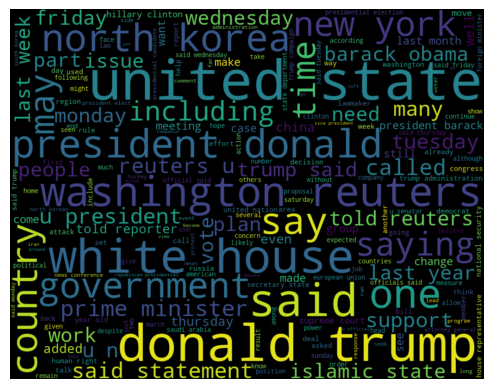

In [26]:
# Common words in the true news (text) dataset (visualized big and bold)
word_wrap = " ".join([sentence for sentence in fake_true_merged["text"][fake_true_merged["OUTCOME"]==1]])

wordcloud = WordCloud(width=1024, height=800, random_state=54, max_font_size=120).generate(word_wrap)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

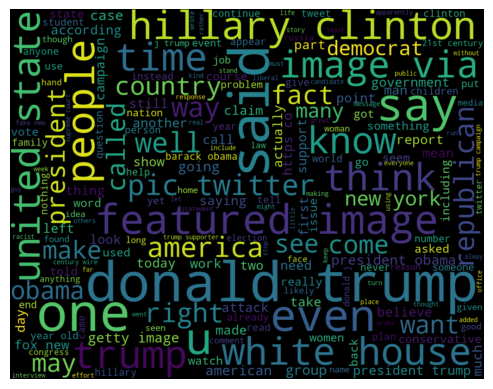

In [27]:
# Common words in the fake news (text) dataset (visualized big and bold)
word_wrap = " ".join([sentence for sentence in fake_true_merged["text"][fake_true_merged["OUTCOME"]==0]])

wordcloud = WordCloud(width=1024, height=800, random_state=54, max_font_size=120).generate(word_wrap)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

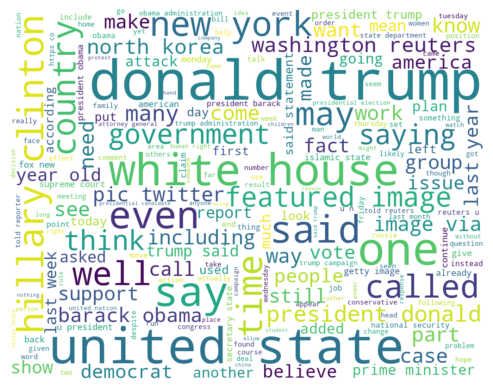

In [28]:
# Common words in the fake_true_merged (text) dataset (visualized big and bold)

word_wrap = " ".join(fake_true_merged["text"])+" "

wordcloud = WordCloud(width=1024, height=800, random_state=54, background_color ='white', max_font_size=120).generate(word_wrap)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## MACHINE LEARNING MODEL

**_The models used here are high in accuracy & very efficient in the detection of fake news online.  
The models have their pros & cons which are noticeable on experiment. Analysis of these models can be  
found inside the paper for this project._**

## 5. Vectorization

In [29]:
corpus = fake_true_merged["text"]
vectorizer = TfidfVectorizer()
x = vectorizer.fit(corpus)

In [30]:
x = vectorizer.fit_transform(corpus)

In [31]:
# Function to check memory allocation before train-test

tracemalloc.start()


snapshot = tracemalloc.take_snapshot()

## SVM

In [32]:
y = fake_true_merged["OUTCOME"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state =101)

In [33]:
scores = {}

In [34]:
SVM_model = LinearSVC(max_iter=100, C=1.0)
SVM_model.fit(x_train, y_train)

y_pred_SVM = SVM_model.predict(x_test)
print(cross_val_score(SVM_model, x, y, cv=3))
print(accuracy_score(y_pred_SVM, y_test))

[0.99380447 0.99332743 0.99448492]
0.9940996255531601


In [35]:
scores["LinearSVC"] = accuracy_score(y_pred_SVM, y_test)

In [36]:
print(classification_report(y_test, y_pred_SVM))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4482
           1       0.99      0.99      0.99      4331

    accuracy                           0.99      8813
   macro avg       0.99      0.99      0.99      8813
weighted avg       0.99      0.99      0.99      8813



## XGBOOST

In [37]:
XGB_model = XGBClassifier(eval_metric='rmse', use_label_encoder=False)
XGB = XGB_model.fit(x_train, y_train)

y_pred_XGB = XGB_model.predict(x_test)
print(cross_val_score(XGB_model, x, y, cv=3))
print(accuracy_score(y_pred_XGB, y_test))

[0.99754902 0.99795738 0.99788929]
0.997390218994667


In [38]:
scores["XGB"] = accuracy_score(y_pred_XGB, y_test)

In [39]:
print(classification_report(y_test, y_pred_XGB))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4482
           1       1.00      1.00      1.00      4331

    accuracy                           1.00      8813
   macro avg       1.00      1.00      1.00      8813
weighted avg       1.00      1.00      1.00      8813



## NAIVE BAYES

In [40]:
NB_model = MultinomialNB()
NB_model.fit(x_train, y_train)

y_pred_MNB = NB_model.predict(x_test)
print(cross_val_score(NB_model, x, y, cv=3))
print(accuracy_score(y_pred_MNB, y_test))

[0.93341503 0.93776809 0.93790427]
0.9363440372177465


In [41]:
scores["MultinomialNB"] = accuracy_score(y_pred_MNB, y_test)

In [42]:
print(classification_report(y_test, y_pred_MNB))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4482
           1       0.94      0.93      0.94      4331

    accuracy                           0.94      8813
   macro avg       0.94      0.94      0.94      8813
weighted avg       0.94      0.94      0.94      8813



In [43]:
# Function to check memory allocation after train-test

tracemalloc.start()


snapshot_1 = tracemalloc.take_snapshot()

In [44]:
# Function to display memory allocation difference before and after train-test
tracemalloc.start()


top_stats = snapshot_1.compare_to(snapshot, 'lineno')

print("[ Top 7 differences ]")
for stat in top_stats[:7]:
    print(stat)

[ Top 7 differences ]
C:\Users\DELL\Anaconda3\lib\site-packages\scipy\sparse\_compressed.py:707: size=56.6 MiB (+56.6 MiB), count=6 (+6), average=9659 KiB
C:\Users\DELL\Anaconda3\lib\site-packages\scipy\sparse\_compressed.py:706: size=28.3 MiB (+28.3 MiB), count=6 (+6), average=4829 KiB
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:872: size=1894 KiB (+1894 KiB), count=2 (+2), average=947 KiB
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:698: size=1894 KiB (+1894 KiB), count=2 (+2), average=947 KiB
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1186: size=947 KiB (+947 KiB), count=4 (+4), average=237 KiB
C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\series.py:931: size=344 KiB (+344 KiB), count=6 (+6), average=57.4 KiB
C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1577: size=344 KiB (+344 KiB), count=5 (+5), average=68.9 KiB


## DEEP LEARNING: LSTM (Long Short-Term Memory)

## 6. Tokenization

In [45]:
# Drop index in dataframe
fake_true_merged = fake_true_merged.reset_index(drop=True)
fake_true_merged

text  OUTCOME
0      davos switzerland reuters argentine president ...        1
1      hero response threat islamic terror reminds us...        0
2      democratic national committee dnc chairwoman d...        0
3      belfast reuters leader british far right group...        1
4      buenos aires reuters major parties running sun...        1
...                                                  ...      ...
44057  dublin reuters irish musician activist bob gel...        1
44058  maputo reuters mozambique fired head intellige...        1
44059  paris reuters french president emmanuel macron...        1
44060  wait one damn minute already another effort sp...        0
44061  london reuters abdul daoud spilt cappuccino sa...        1

[44062 rows x 2 columns]

In [46]:
# dependent feature
y = fake_true_merged["OUTCOME"]

# Independent feature
x = fake_true_merged["text"]

In [47]:
# Delegate value for sentence length
sent_length = 120

In [48]:
# Tokenizing text (independent variable) using keras.preprocessing.
# texts_to_sequences assigns an integer value to token for indexing purpose.

token = Tokenizer(num_words = sent_length, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n', lower = True, split = ' ')
token.fit_on_texts(x)
x = token.texts_to_sequences(x)

## 7. Word embedding or padding

In [49]:
# Adding character (pre or post) to strings to match specified maximum length.
# Padding for those less and truncating for those above

x = pad_sequences(sequences=x, maxlen=sent_length, padding='post', truncating='post')

## 8. Model (Training)

In [50]:
# Train_Test_Split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=101)

# Designated value for important model variable
embedding_vector_features = 50
batch_size = 300
voc_size = 5000

# Training
model = Sequential(name = 'lstm_model')
model.add(layer = Embedding(voc_size, embedding_vector_features, input_length=sent_length, name='1st_Layer'))
model.add(layer = LSTM(units=140, dropout=0.2, recurrent_dropout=0.2, name='2nd_Layer'))
model.add(layer = Dropout(rate=0.5, name='3rd_Layer'))
model.add(layer = Dense(units=len(set(y)), activation = 'sigmoid', name='Output_Layer'))

# Compiling the model
# optimizer adam acts like a stabilizer for LSTM
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

In [51]:
model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_Layer (Embedding)       (None, 120, 50)           250000    
                                                                 
 2nd_Layer (LSTM)            (None, 140)               106960    
                                                                 
 3rd_Layer (Dropout)         (None, 140)               0         
                                                                 
 Output_Layer (Dense)        (None, 2)                 282       
                                                                 
Total params: 357,242
Trainable params: 357,242
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_fit = model.fit(x_train, y_train, validation_split=0.2, epochs=5, shuffle=True, verbose=1)

Epoch 1/5
882/882 [==============================] - 143s 157ms/step - loss: 0.3979 - accuracy: 0.7770 - val_loss: 0.1538 - val_accuracy: 0.9606
Epoch 2/5
882/882 [==============================] - 148s 168ms/step - loss: 0.1860 - accuracy: 0.9497 - val_loss: 0.2039 - val_accuracy: 0.9369
Epoch 3/5
882/882 [==============================] - 145s 165ms/step - loss: 0.2379 - accuracy: 0.9175 - val_loss: 0.2391 - val_accuracy: 0.9224
Epoch 4/5
882/882 [==============================] - 140s 159ms/step - loss: 0.2091 - accuracy: 0.9372 - val_loss: 0.1749 - val_accuracy: 0.9488
Epoch 5/5
882/882 [==============================] - 140s 159ms/step - loss: 0.1591 - accuracy: 0.9575 - val_loss: 0.1298 - val_accuracy: 0.9678


### LSTM Performance Metrics

In [53]:
print("Accuracy of model on train data is ------->" , model.evaluate(x_train, y_train)[1]*100 , "%")
print("Accuracy of model on test data is -------->" , model.evaluate(x_test, y_test)[1]*100 , "%")

1102/1102 [==============================] - 29s 26ms/step - loss: 0.1214 - accuracy: 0.9714
Accuracy of model on train data is -------> 97.1403419971466 %
276/276 [==============================] - 8s 27ms/step - loss: 0.1214 - accuracy: 0.9713
Accuracy of model on test data is --------> 97.12924361228943 %


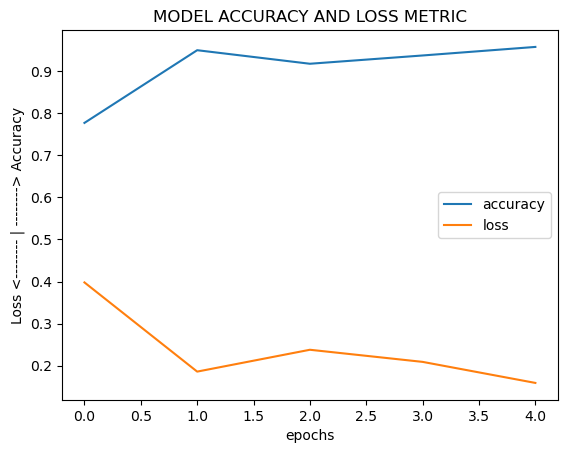

In [54]:
# Plot : Accuracy and Loss metric for trained data
plt.figure()
plt.plot(model_fit.history['accuracy'], label = 'accuracy')
plt.plot(model_fit.history['loss'], label = 'loss')
plt.title("MODEL ACCURACY AND LOSS METRIC")
plt.ylabel("Loss <-------- | --------> Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()


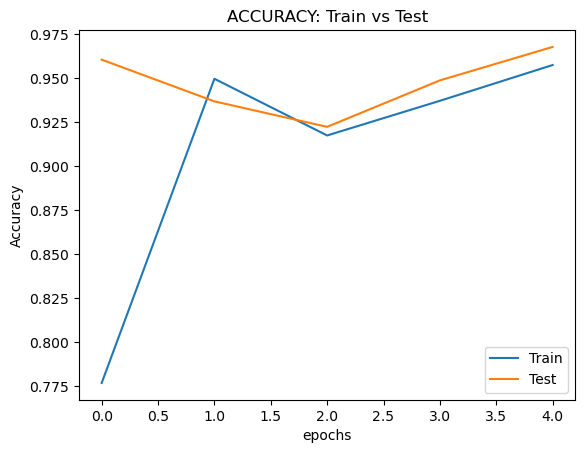

In [55]:
# Plot : Trained data accuracy vs Test data val_accuracy
plt.figure()
plt.plot(model_fit.history['accuracy'], label = 'Train')
plt.plot(model_fit.history['val_accuracy'], label = 'Test')
plt.title("ACCURACY: Train vs Test")
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

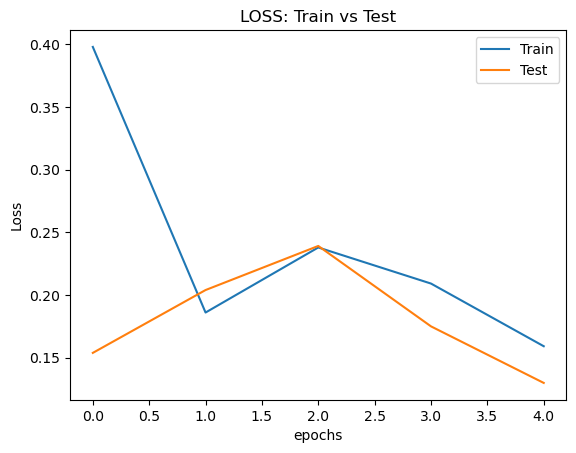

In [56]:
# Plot : Trained data loss vs Test data val_loss
plt.figure()
plt.plot(model_fit.history['loss'], label = 'Train')
plt.plot(model_fit.history['val_loss'], label = 'Test')
plt.title("LOSS: Train vs Test")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

## 9. Bag of Word (Feature extraction)

In [57]:
# Select the first specific number (4000) of rows
df = fake_true_merged.iloc[:4000]
df

text  OUTCOME
0     davos switzerland reuters argentine president ...        1
1     hero response threat islamic terror reminds us...        0
2     democratic national committee dnc chairwoman d...        0
3     belfast reuters leader british far right group...        1
4     buenos aires reuters major parties running sun...        1
...                                                 ...      ...
3995  grew hometown rural michigan kid rock aka bob ...        0
3996  weekend donald trump bashing civil rights icon...        0
3997  reuters eye potentially catastrophic category ...        1
3998  shanghai reuters days taking china leader 2012...        1
3999  hillary clinton visited predominately black ch...        0

[4000 rows x 2 columns]

In [58]:
vect=CountVectorizer()
trans = vect.fit_transform(df['text'])
print (df['text'])

0       davos switzerland reuters argentine president ...
1       hero response threat islamic terror reminds us...
2       democratic national committee dnc chairwoman d...
3       belfast reuters leader british far right group...
4       buenos aires reuters major parties running sun...
                              ...                        
3995    grew hometown rural michigan kid rock aka bob ...
3996    weekend donald trump bashing civil rights icon...
3997    reuters eye potentially catastrophic category ...
3998    shanghai reuters days taking china leader 2012...
3999    hillary clinton visited predominately black ch...
Name: text, Length: 4000, dtype: object


In [59]:
trans.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [60]:
data_for_xai = pd.DataFrame(trans.toarray(), columns = vect.get_feature_names())
data_for_xai

00  000  0000  00007  000have  000th  002  003  005380  006  ...  \
0      0    0     0      0        0      0    0    0       0    0  ...   
1      0    0     0      0        0      0    0    0       0    0  ...   
2      0    0     0      0        0      0    0    0       0    0  ...   
3      0    0     0      0        0      0    0    0       0    0  ...   
4      0    1     0      0        0      0    0    0       0    0  ...   
...   ..  ...   ...    ...      ...    ...  ...  ...     ...  ...  ...   
3995   0    0     0      0        0      0    0    0       0    0  ...   
3996   0    0     0      0        0      0    0    0       0    0  ...   
3997   0    0     0      0        0      0    0    0       0    0  ...   
3998   0    0     0      0        0      0    0    0       0    0  ...   
3999   0    0     0      0        0      0    0    0       0    0  ...   

      zurich  zus  zushm0asnc  zvd5c3qb34  zwa  zx7cpswa  zx7gkfbuv4  zyklon  \
0          0    0           0           0    0         0           0       0   
1          0    0           0           0    0         0           0       0   
2          0    0           0           0    0         0           0       0   
3          0    0           0           0    0         0           0       0   
4          0    0           0           0    0         0           0       0   
...      ...  ...         ...         ...  ...       ...         ...     ...   
3995       0    0           0           0    0         0           0       0   
3996       0    0           0           0    0         0           0       0   
3997       0    0           0           0    0         0           0       0   
3998       0    0           0           0    0         0           0       0   
3999       0    0           0           0    0         0           0       0   

      zypries  zzn3bqnfsk  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  
...       ...         ...  
3995        0           0  
3996        0           0  
3997        0           0  
3998        0           0  
3999        0           0  

[4000 rows x 43271 columns]

In [61]:
# Just to show how to transpose. Flip column and row
data_for_xai.T.sort_values(by=0, ascending=False).head(4000)

0     1     2     3     4     5     6     7     8     9     ...  \
reuters        2     0     0     1     2     2     1     0     1     1  ...   
president      2     0     0     1     2     2     5     0     2     5  ...   
december       1     0     0     0     0     0     0     0     0     0  ...   
new            1     0     0     0     0     0     0     0     0     1  ...   
trump          1     0     0     2     0     2     2     0     5    13  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
reclad         0     0     0     0     0     0     0     0     0     0  ...   
recladding     0     0     0     0     0     0     0     0     0     0  ...   
reclaim        0     0     0     0     0     0     0     0     0     0  ...   
reclaimed      0     0     0     0     0     0     0     0     0     0  ...   
reclaiming     0     0     0     0     0     0     0     0     0     0  ...   

            3990  3991  3992  3993  3994  3995  3996  3997  3998  3999  
reuters        0     0     1     2     2     0     0     1     1     0  
president      0     1     3     4     2     2     1     0     1     1  
december       0     0     0     0     0     1     0     0     1     0  
new            0     1     2     0     1     1     0     0     1     0  
trump          0     3     0     7     0     6    10     0     0     0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
reclad         0     0     0     0     0     0     0     0     0     0  
recladding     0     0     0     0     0     0     0     0     0     0  
reclaim        0     0     0     0     0     0     0     0     0     0  
reclaimed      0     0     0     0     0     0     0     0     0     0  
reclaiming     0     0     0     0     0     0     0     0     0     0  

[4000 rows x 4000 columns]

In [62]:
# Type any word to see how often it appears.
data_for_xai['trump'].sum()

11715

## 10. Explainable AI (XAI)

In [63]:
# Create a dataset that has only the variable OUTCOME

only_outcome_col = fake_true_merged.drop(['text'], axis=1)

In [64]:
# Limit to specific row

only_outcome_col = only_outcome_col.iloc[:4000]

In [65]:
# Merge dataset from feature extraction(data_for_xai) with dataset with only OUTCOME(only_outcome_col)
xai_dataset = pd.concat([data_for_xai, only_outcome_col], axis=1)

In [66]:
xai_dataset

00  000  0000  00007  000have  000th  002  003  005380  006  ...  zus  \
0      0    0     0      0        0      0    0    0       0    0  ...    0   
1      0    0     0      0        0      0    0    0       0    0  ...    0   
2      0    0     0      0        0      0    0    0       0    0  ...    0   
3      0    0     0      0        0      0    0    0       0    0  ...    0   
4      0    1     0      0        0      0    0    0       0    0  ...    0   
...   ..  ...   ...    ...      ...    ...  ...  ...     ...  ...  ...  ...   
3995   0    0     0      0        0      0    0    0       0    0  ...    0   
3996   0    0     0      0        0      0    0    0       0    0  ...    0   
3997   0    0     0      0        0      0    0    0       0    0  ...    0   
3998   0    0     0      0        0      0    0    0       0    0  ...    0   
3999   0    0     0      0        0      0    0    0       0    0  ...    0   

      zushm0asnc  zvd5c3qb34  zwa  zx7cpswa  zx7gkfbuv4  zyklon  zypries  \
0              0           0    0         0           0       0        0   
1              0           0    0         0           0       0        0   
2              0           0    0         0           0       0        0   
3              0           0    0         0           0       0        0   
4              0           0    0         0           0       0        0   
...          ...         ...  ...       ...         ...     ...      ...   
3995           0           0    0         0           0       0        0   
3996           0           0    0         0           0       0        0   
3997           0           0    0         0           0       0        0   
3998           0           0    0         0           0       0        0   
3999           0           0    0         0           0       0        0   

      zzn3bqnfsk  OUTCOME  
0              0        1  
1              0        0  
2              0        0  
3              0        1  
4              0        1  
...          ...      ...  
3995           0        0  
3996           0        0  
3997           0        1  
3998           0        1  
3999           0        0  

[4000 rows x 43272 columns]

In [67]:
xai_dataset = xai_dataset.iloc[:4000]

In [68]:
xai_dataset.head(10)

00  000  0000  00007  000have  000th  002  003  005380  006  ...  zus  \
0   0    0     0      0        0      0    0    0       0    0  ...    0   
1   0    0     0      0        0      0    0    0       0    0  ...    0   
2   0    0     0      0        0      0    0    0       0    0  ...    0   
3   0    0     0      0        0      0    0    0       0    0  ...    0   
4   0    1     0      0        0      0    0    0       0    0  ...    0   
5   0    0     0      0        0      0    0    0       0    0  ...    0   
6   0    0     0      0        0      0    0    0       0    0  ...    0   
7   0    0     0      0        0      0    0    0       0    0  ...    0   
8   0    0     0      0        0      0    0    0       0    0  ...    0   
9   0    0     0      0        0      0    0    0       0    0  ...    0   

   zushm0asnc  zvd5c3qb34  zwa  zx7cpswa  zx7gkfbuv4  zyklon  zypries  \
0           0           0    0         0           0       0        0   
1           0           0    0         0           0       0        0   
2           0           0    0         0           0       0        0   
3           0           0    0         0           0       0        0   
4           0           0    0         0           0       0        0   
5           0           0    0         0           0       0        0   
6           0           0    0         0           0       0        0   
7           0           0    0         0           0       0        0   
8           0           0    0         0           0       0        0   
9           0           0    0         0           0       0        0   

   zzn3bqnfsk  OUTCOME  
0           0        1  
1           0        0  
2           0        0  
3           0        1  
4           0        1  
5           0        1  
6           0        1  
7           0        0  
8           0        1  
9           0        1  

[10 rows x 43272 columns]

In [69]:
# Dependent feature
Y = xai_dataset['OUTCOME']

# Independent feature
X = xai_dataset.drop('OUTCOME', axis = 1)

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =0)

### SHAP

In [71]:
# XGB model preferrably used for SHAP analysis
model_xgb_SHAP = XGBClassifier(eval_metric='rmse', use_label_encoder=False)
xgb = model_xgb_SHAP.fit(X_train , Y_train)

In [72]:
model_xgb_SHAP.predict(X_test)

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,

In [73]:
# Help in visualization of SHAP plot
shap.initjs()

In [74]:
explainer = shap.Explainer(model_xgb_SHAP)

In [75]:
# Use ********  shap_values = explainer(X[0:200]) *******   for specific range
shap_values = explainer(X)

In [76]:
# View shape of shap values
np.shape(shap_values.values)

(4000, 43271)

In [77]:
# Note that OUTCOME is    0=fake     1=True
print(xai_dataset.iloc[5])

00            0
000           0
0000          0
00007         0
000have       0
             ..
zx7gkfbuv4    0
zyklon        0
zypries       0
zzn3bqnfsk    0
OUTCOME       1
Name: 5, Length: 43272, dtype: int64


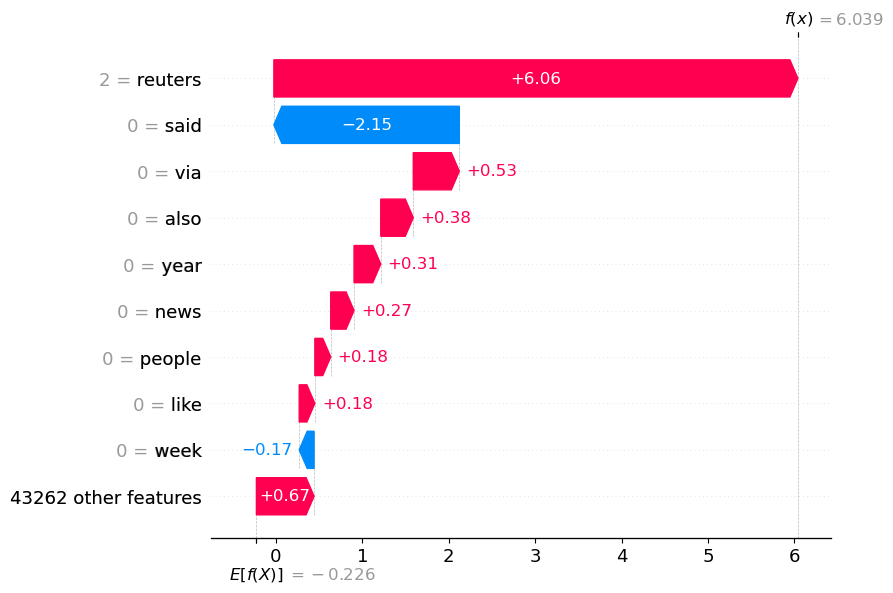

In [78]:
# Waterfall plot explaining decision taken on specified index of dataset
shap.plots.waterfall(shap_values[5], max_display=10)

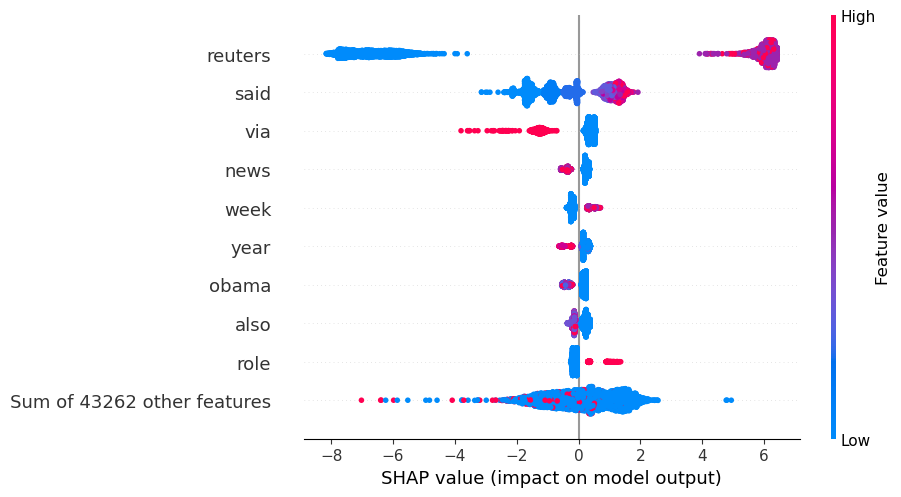

In [79]:
shap.plots.beeswarm(shap_values)

In [80]:
# Force plot explaining decision taken on specified index of dataset
shap.plots.force(shap_values[8])

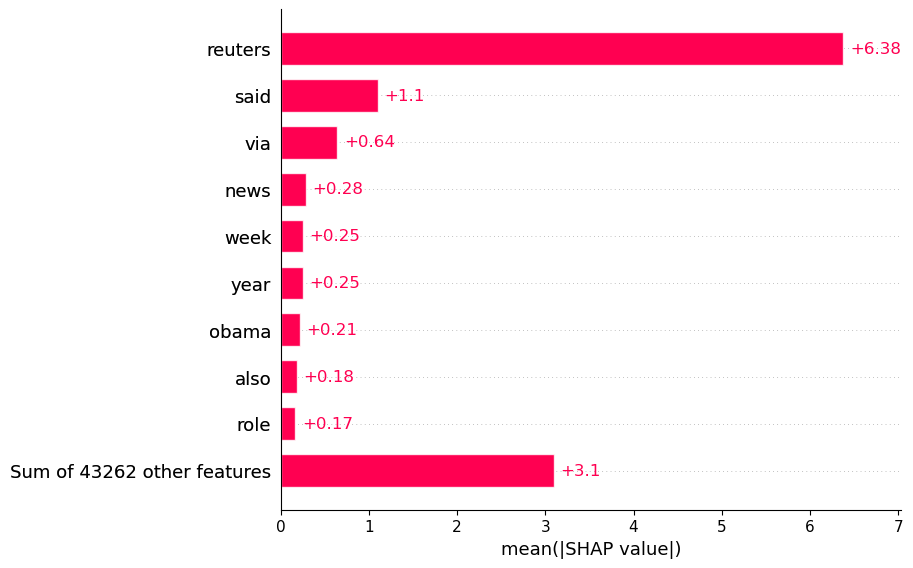

In [81]:
# Barplot for shap values
shap.plots.bar(shap_values)

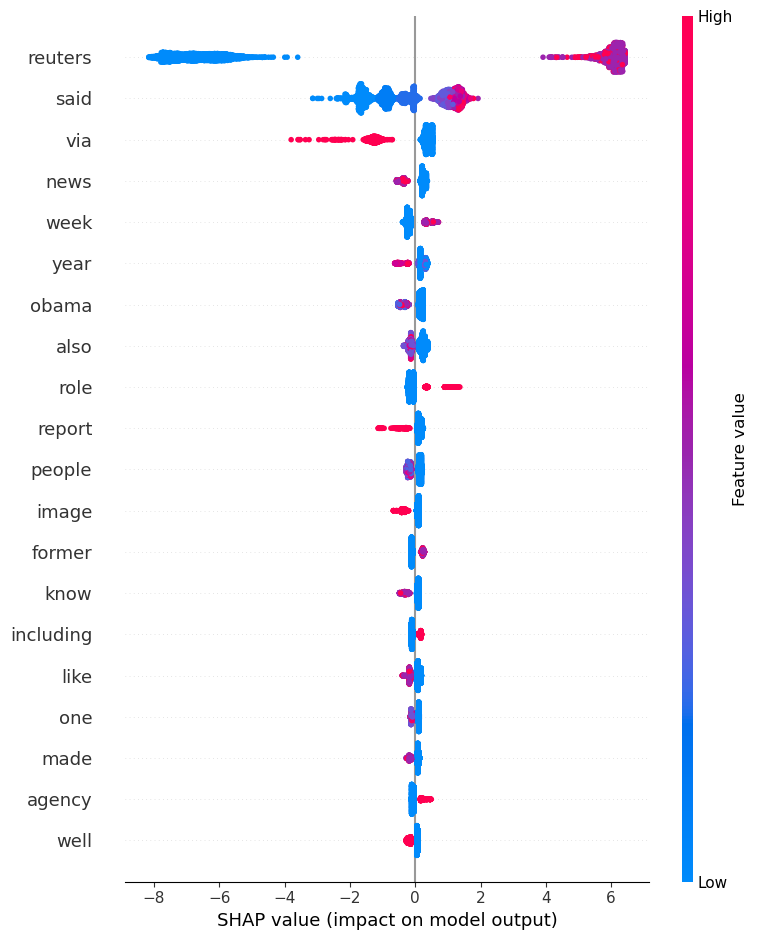

In [82]:
shap.summary_plot(shap_values, X)

### LIME

In [83]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values, class_names=['MEDV'], verbose=True, mode='regression')

In [84]:
exp = explainer.explain_instance(X_test.values[3], model_xgb_SHAP.predict, num_features=10)

Intercept 0.2149055136318959
Prediction_local [-0.08087123]
Right: 0


In [85]:
exp.show_in_notebook(show_table=True)

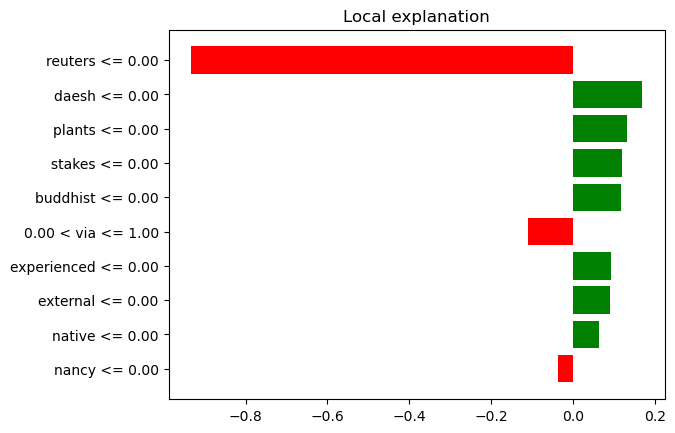

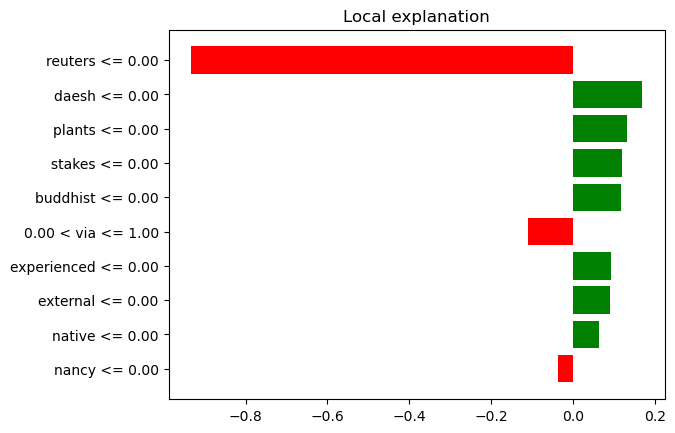

In [86]:
exp.as_pyplot_figure()

## 11. Conclusion

**AI models used for detection of online fake news are proficient and have high accuracy. XGBoost has high scalability
and LSTM has high learning capability with more layers added to it. There is no best model, as models used here have high accuracy, choice of models are relative to complexity of dataset. SHAP and LIME explainers can explain models decision globally and locally respectively. From the above analysis generated by both LIME and SHAP, inference can be made knowing that "reuters" is a high contributor and determinant to know if a news is fake or true in this research. Source of news is a main factor to know the credibility of news, as "reuters" is a news publisher.**